In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

C:\Users\Admin\AppData\Local\Temp\ipykernel_29680\3775491579.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Block Numa warning

In [3]:
dataset_folder = "D:\EuroSAT"

In [4]:
import pandas as pd

# Define column names
column_names = ["id", "path", "class_id", "class_name"]

# Load dataframes
training_df = pd.read_csv(r"D:\EuroSAT\train.csv", names=column_names)
validation_df = pd.read_csv(r"D:\EuroSAT\validation.csv", names=column_names)
test_df = pd.read_csv(r"D:\EuroSAT\test.csv", names=column_names)

In [5]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")

Training set size: 18901 (70%)
Validation set size: 5401 (20%)
Test set size: 2701 (10%)


In [6]:
rescaling_factor = 1. / 255

In [7]:
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

In [8]:
image_width = 64
image_height = 64

In [9]:
batch_size = 128

In [10]:
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
      class_mode="categorical",
    shuffle="true",
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 18900 validated image filenames belonging to 10 classes.


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [11]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)
print(pd.Series(count, index=class_name_list))

AnnualCrop              2100
Forest                  2100
HerbaceousVegetation    2100
Highway                 1750
Industrial              1750
Pasture                 1400
PermanentCrop           1750
Residential             2100
River                   1750
SeaLake                 2100
dtype: int64


In [12]:
figure_height = 3
figure_width = 3
figure_size = (14, 14)

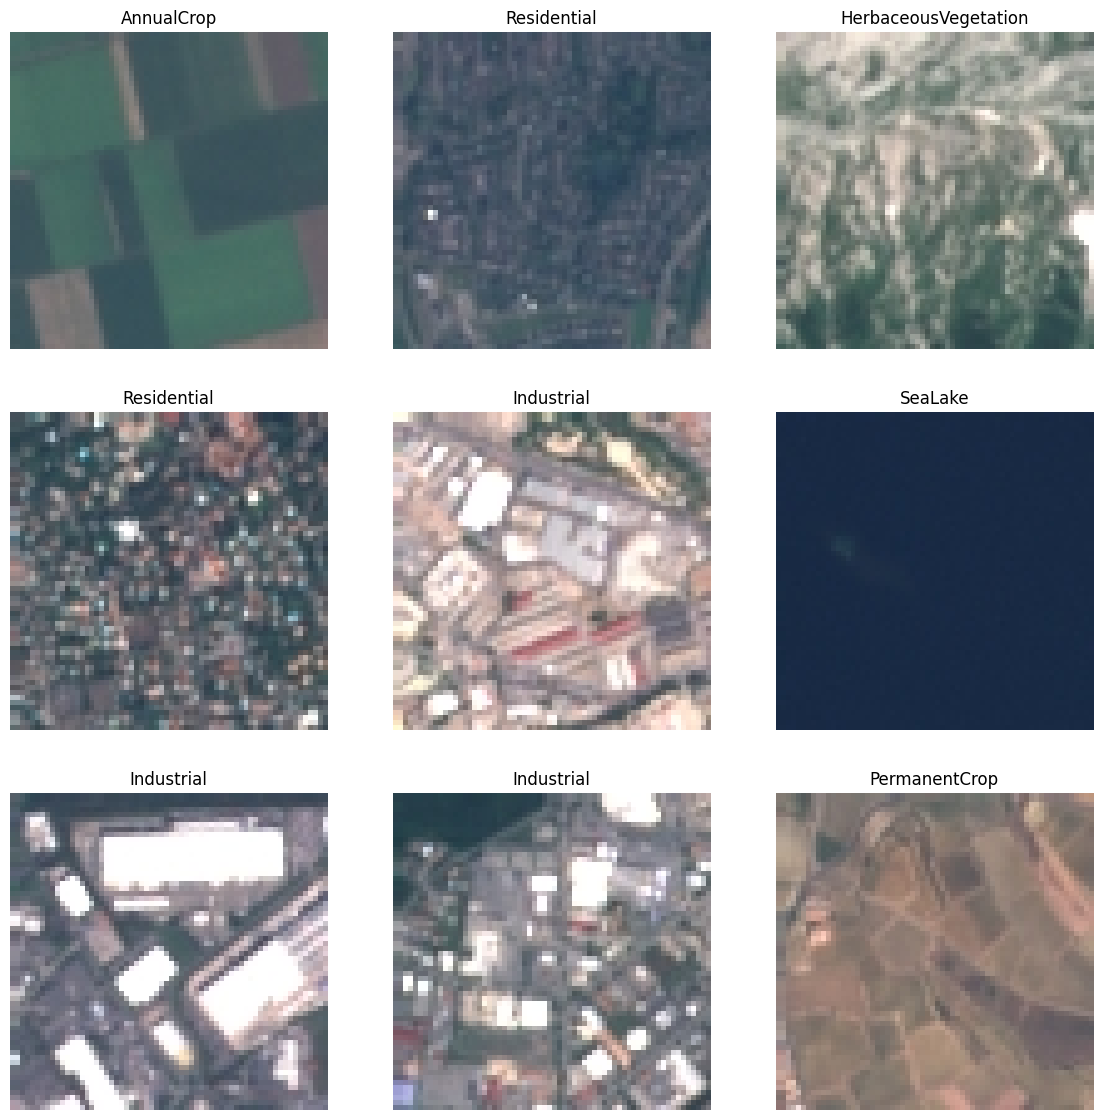

In [13]:
images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(images[index])
    plt.title(class_name_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

In [14]:
base_model = VGG16(include_top=False, input_shape=(64, 64, 3))
base_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [15]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 15768906 (60.15 MB)
Trainable params: 15768906 (60.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model_path = "/kaggle/working/models/eurosat_rgb_model.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [18]:
model.save('my_model.keras')

In [19]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=10,
    verbose=1,
)

Epoch 1/10


148/148 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.7697

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 775s 5s/step - loss: 0.6668 - accuracy: 0.7697 - val_loss: 0.3297 - val_accuracy: 0.8907 - lr: 1.0000e-04
Epoch 2/10
148/148 [==============================] - 934s 6s/step - loss: 0.2218 - accuracy: 0.9274 - val_loss: 0.1483 - val_accuracy: 0.9526 - lr: 1.0000e-04
Epoch 3/10
148/148 [==============================] - 680s 5s/step - loss: 0.1427 - accuracy: 0.9546 - val_loss: 0.1475 - val_accuracy: 0.9502 - lr: 1.0000e-04
Epoch 4/10
148/148 [==============================] - 664s 4s/step - loss: 0.1405 - accuracy: 0.9546 - val_loss: 0.1550 - val_accuracy: 0.9498 - lr: 1.0000e-04
Epoch 5/10
148/148 [==============================] - 645s 4s/step - loss: 0.0807 - accuracy: 0.9739 - val_loss: 0.1762 - val_accuracy: 0.9413 - lr: 1.0000e-04
Epoch 6/10
148/148 [==============================] - 653s 4s/step - loss: 0.0742 - accuracy: 0.9743 - val_loss: 0.1445 - val_accuracy: 0.9533 - lr: 1.0000e-04
Epoch 7/10
148/148 [==============================]

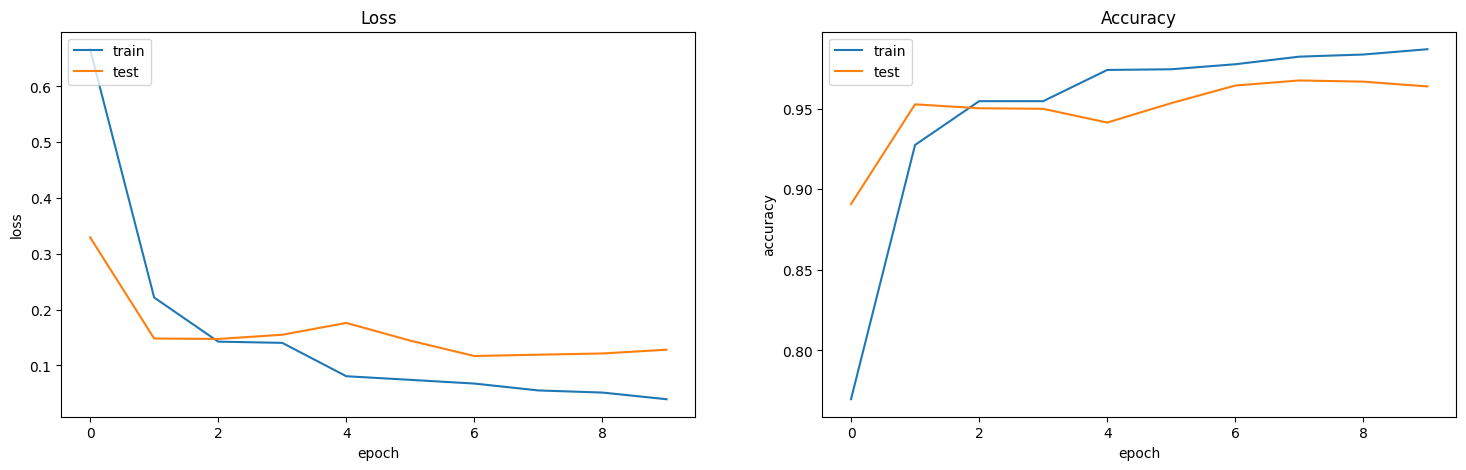

In [21]:

plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()

In [22]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 67s 3s/step - loss: 0.1120 - accuracy: 0.9689


In [23]:
test_set.reset()

In [24]:
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 21s 7ms/step


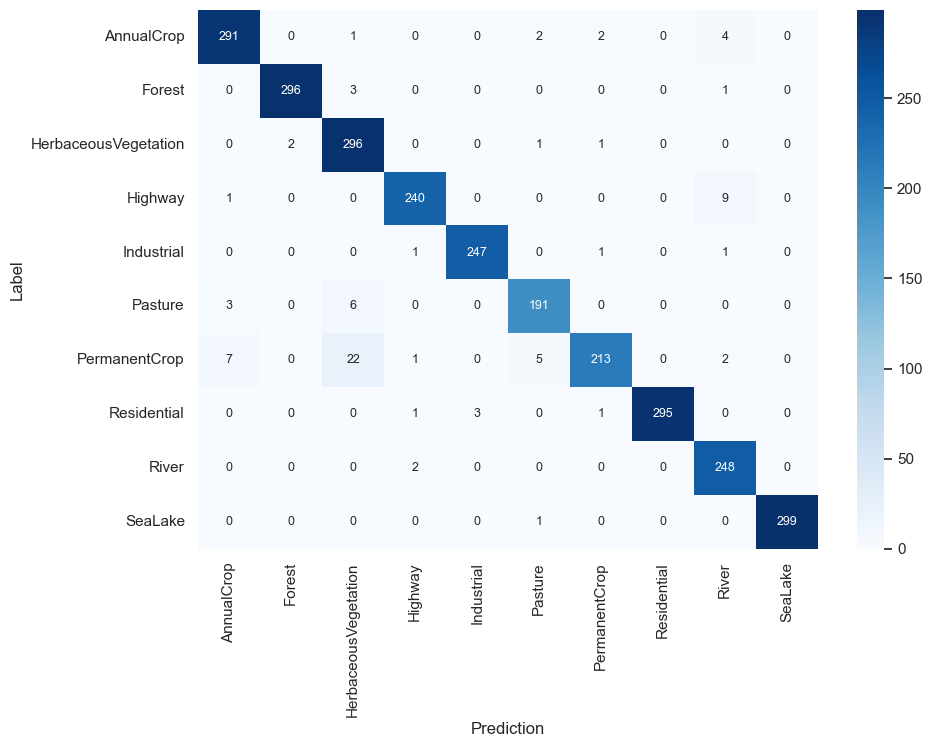

In [25]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.show()


In [26]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

In [28]:
correct = results_df["label"] == results_df["prediction"]
correct_df = results_df[correct]

print(f"{len(correct_df)} correct predictions out of {len(results_df)}")

2616 correct predictions out of 2700


In [29]:
correct_predictions = (class_name_list[pred] for pred in correct_df["prediction"])
correct_labels = (class_name_list[label] for label in correct_df["label"])
correct_images = (image.imread(path) for path in correct_df["path"])

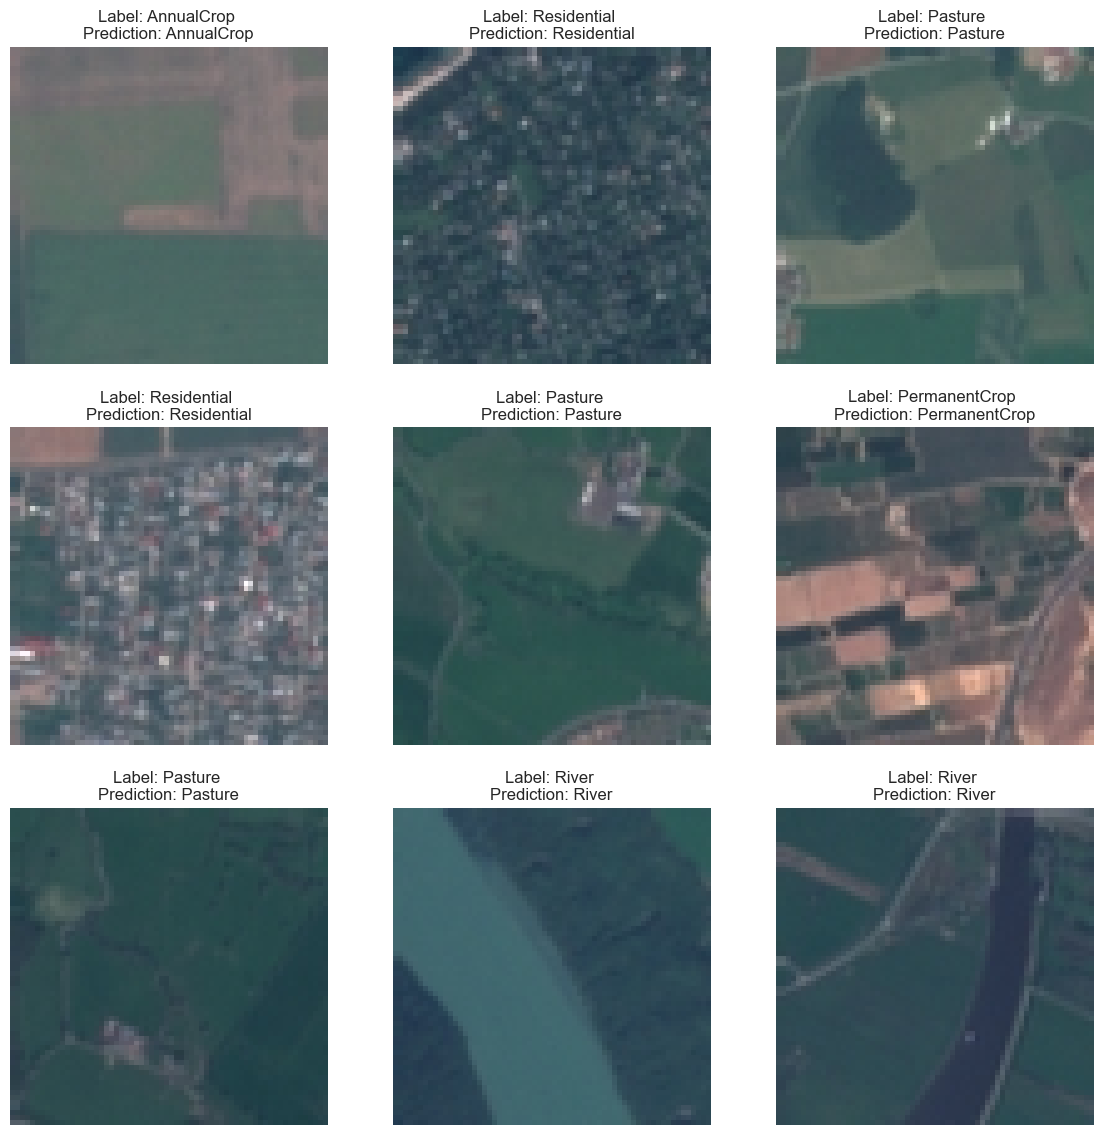

In [30]:
figure_size = (14, 14)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(correct_predictions)
    prediction = next(correct_labels)
    picture = next(correct_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")